In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
from datasets import load_dataset

C:\Users\ash\scoop\apps\python\current\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = 'cuda:0'

In [4]:
imdb_dataset = load_dataset("imdb", download_mode="reuse_cache_if_exists")

train_dataset = imdb_dataset["train"]
test_dataset = imdb_dataset["test"]

print(len(train_dataset))
print(len(test_dataset))

Generating unsupervised split: 100%|██████████████████████████████████| 50000/50000 [00:00<00:00, 476192.55 examples/s]


25000
25000


In [5]:
def multihead_attention_fn(Q, K, V, nheads):
    Q = Q.chunk(nheads, dim=-1)
    K = K.chunk(nheads, dim=-1)
    V = V.chunk(nheads, dim=-1)

    outputs = []
    weights = []
    for i in range(nheads):
        Q_i = Q[i]
        K_i = K[i]
        V_i = V[i]

        downscaler = torch.sqrt(torch.tensor(Q_i.size(-1)))
        
        # attention scores (b, m, n)
        S = torch.matmul(Q_i, K_i.transpose(-2, -1)) / downscaler  # 4,2,10 -> 4,10,2
    
        attention_weights = nn.functional.softmax(S, dim=-1)
        
        out = torch.matmul(
            attention_weights,
            V_i
        )
        outputs.append(out)
        weights.append(attention_weights)

    out = torch.cat(outputs, dim=-1)
    attention_weights = torch.stack(weights, dim=1)

    return out, attention_weights


class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, nheads):
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim
        self.nheads = nheads

        self.Ql = nn.Linear(input_dim, input_dim, bias=False)
        self.Kl = nn.Linear(input_dim, input_dim, bias=False)
        self.Vl = nn.Linear(input_dim, input_dim, bias=False)

    def forward(self, Q, K, V):
        out, attention_weights = multihead_attention_fn(
            self.Ql(Q),
            self.Kl(K),
            self.Vl(V),
            self.nheads
        )
        return out, attention_weights

In [6]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(Word2Vec, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

    def forward(self, x):
        x = self.embedding(x)
        return x

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=5000): # embedding dim should match model size
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout()

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # term in the denominator of the exponent for the sinusoidal function
        # creates different frequencies based on the dimension
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))
        # compute sin for even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # compute cos for odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        # add batch dimension
        pe = pe.unsqueeze(0)
        # put pe into non-parameter loadable state
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :] # all elements from pe up to the size of x second dim
        x = self.dropout(x)
        return x


In [8]:
SEQUENCE_LEN = 0

In [9]:
BATCH_SIZE = 4

In [10]:
# BOS and EOS aren't really needed when every instance of input is treated as a sentence

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
BOS_TOKEN = '<BOS>'
EOS_TOKEN = '<EOS>'

PAD_TOKEN_IND = 0
UNK_TOKEN_IND = 1
BOS_TOKEN_IND = 2
EOS_TOKEN_IND = 3

VOCAB = {
    UNK_TOKEN: UNK_TOKEN_IND,
    PAD_TOKEN: PAD_TOKEN_IND,
    BOS_TOKEN: BOS_TOKEN_IND,
    EOS_TOKEN: EOS_TOKEN_IND,
}


def tokenize_and_build_vocab(list_of_strings, inference=False):
    res = []
    for st in list_of_strings:
        tokens = st.split(' ')
        tokens.insert(0, BOS_TOKEN)
        tokens.append(EOS_TOKEN)
        res.append(tokens)

        if not inference:
            # we can also filter tokens that are not frequent enough then mark those words as <UNK>
            for token in tokens:
                if token not in VOCAB:
                    VOCAB[token] = len(VOCAB)
    
    return res


def vectorize(list_of_lists_of_tokens, inference=False):
    global SEQUENCE_LEN

    pad_len = max(len(indices) for indices in list_of_lists_of_tokens)

    if inference:
        pad_len = SEQUENCE_LEN
    else:
        SEQUENCE_LEN = pad_len    
    
    res = []
    for tl in list_of_lists_of_tokens:
        sent = []
        for token in tl:
            ind = 0
            if token in VOCAB:
                ind = VOCAB[token]
            else:
                ind = VOCAB[UNK_TOKEN]
            sent.append(ind)
        if len(sent) != pad_len:
            for i in range(pad_len - len(sent)):
                sent.append(0)  # pad the thing so torch.tensor() in collatefn doesn't yell
        res.append(sent)
    return res


def collate(batch):
    # ideally we would pad here
    # but pad_sequence expects a tensor which can't be created with inconsistent lengths ¯\_(ツ)_/¯
    data_batch = []
    label_batch = []
    for data, label in batch:
        data_batch.append(data)
        label_batch.append(label)
    return torch.tensor(data_batch), torch.tensor(label_batch)

In [11]:
import string

def remove_punc(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def preprocess(list_of_sentences, inference=False):
    no_br = [text.replace('<br />', '') for text in list_of_sentences]
    
    # we gonna treat every review as a whole input sentence to avoid contextual discontinuity
    no_cap = [text.lower() for text in no_br]
    no_punc = [remove_punc(text) for text in no_cap]
    
    tokenized_data = tokenize_and_build_vocab(no_punc, inference)

    vectorized_data = vectorize(tokenized_data, inference)

    print(len(vectorized_data))
    print(len(train_dataset['label']))
    return vectorized_data

In [12]:
TRAIN_DATA = preprocess(train_dataset['text'])

25000
25000


In [13]:
train_dataloader = DataLoader(
    list(zip(TRAIN_DATA, train_dataset['label'])),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate
)

In [14]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, nhead=1):
        super(TransformerBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_dim, nhead)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.lin = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        x1 = self.norm1(x)
        a_out, _ = self.attention(x1, x1, x1)
        x = x + a_out

        x2 = self.norm2(x)
        x = x + self.lin(x2)

        return x
    

In [15]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, output_dim=2, depth=1, nhead=1):
        super(Transformer, self).__init__()

        self.embedding = Word2Vec(len(VOCAB), embed_dim)
        self.pos_enc = PositionalEncoding(embed_dim)
        self.transformer_layers = torch.nn.ModuleList([
            TransformerBlock(embed_dim, nhead) for _ in range(depth)
        ])
        self.classifier = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_enc(x)

        # since this is binary classification, we don't generate anything and care only about the encoder
        for layer in self.transformer_layers:
            x = layer(x)

        # mean is not in standard transformer arch
        # we can do this for classification to summarize information across all representations
        x = x.mean(dim=1)
        
        x = self.classifier(x)
        
        return x

In [16]:
model = Transformer(512).to(DEVICE)

In [17]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [18]:
EPOCHS = 5

running_loss = 0
losses = []

In [19]:
for epoch in range(EPOCHS):
    for data, label in train_dataloader:
        data = data.to(DEVICE)
        label = label.to(DEVICE)
        
        optimizer.zero_grad()
        
        out = model(data)
        
        loss = loss_fn(out, label)

        running_loss += loss.item()
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

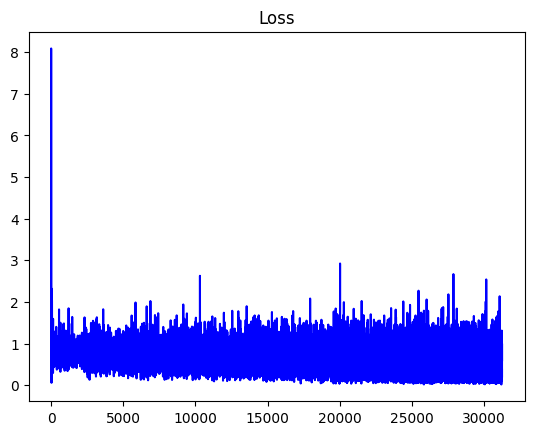

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses, 'b', label='Loss')
plt.title('Loss')
plt.show()

In [21]:
TEST_DATA = preprocess(test_dataset['text'], inference=True)

25000
25000


In [22]:
test_dataloader = DataLoader(
    list(zip(TEST_DATA, test_dataset['label'])),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate
)

In [23]:
correct = 0
total = 0

with torch.no_grad():
	model.eval();
	for data in test_dataloader:
		data, label = data
        
		data = data.to(DEVICE)
		label = label.to(DEVICE)

		out = model(data)
	
		total += label.shape[0]

		preds = torch.argmax(out, dim=1)
		correct += (preds == label).sum().item()

print('total', total)
print('correct', correct)
print('accuracy', round(correct / total, 3))

total 25000
correct 20198
accuracy 0.808
